In [142]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
import warnings
warnings.filterwarnings('ignore')

In [143]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Veri Analizi

In [145]:
data.isnull().values.any()  # Veri seti içerisinde boş veri var mı diye kontrol ediyoruz.

False

Text(0, 0.5, 'Frekansı')

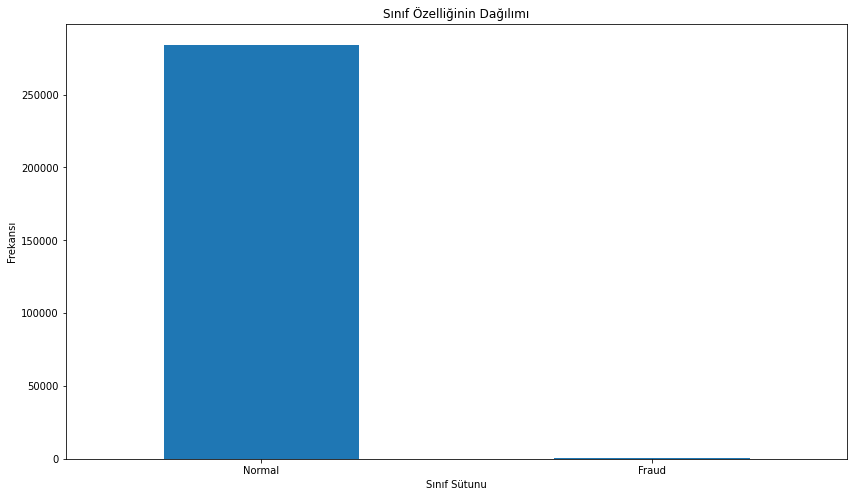

In [146]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

LABELS = ["Normal", "Fraud"]

plt.title("Sınıf Özelliğinin Dağılımı")

plt.xticks(range(2), LABELS)

plt.xlabel("Sınıf Sütunu")

plt.ylabel("Frekansı")

In [147]:
fraud = data[data['Class']==1] # Class sütunu eğer 1 ise bu bize kredi kartının fraud (sahte) olduğunu gösterir.

normal = data[data['Class']==0] # Class sütunu eğer 0 ise bu bize kredi kartının normal olduğunu gösterir.

In [148]:
print("Sahte Kredi Kartı verileri: ", fraud.shape) # Sahte kart verileri
print("Normal Kredi Kartı verileri: ", normal.shape) # Normal kart verileri

Sahte Kredi Kartı verileri:  (492, 31)
Normal Kredi Kartı verileri:  (284315, 31)


In [149]:
normal_data = normal.sample(frac = 0.1,random_state=1) # Çok fazla datamız vardı. Belirli sayıda örnek alarak veri setimizi biraz küçülttük.
normal_data.shape

(28432, 31)

In [150]:
frames = [normal_data, fraud] # Yeni data seti oluşturmak için normal ve hileli kredi kartı verilerini birleştirdik.
result = pd.concat(frames)

In [151]:
data = result.sample(frac=1).reset_index(drop=True)  # Elimizdeki veri setini azaltarak 1 olan değerleri karıştırdık.
data.shape

(28924, 31)

In [152]:
fraud = data[data['Class']==1] # Class sütunu eğer 1 ise bu bize kredi kartının fraud (sahte) olduğunu gösterir.

normal = data[data['Class']==0] # Class sütunu eğer 0 ise bu bize kredi kartının normal olduğunu gösterir.

In [153]:
fraud.Amount.describe() # Sahte verilerin analizi

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [154]:
normal.Amount.describe() # Normal verilerin analizi

count    28432.000000
mean        88.729853
std        237.973364
min          0.000000
25%          5.887500
50%         22.000000
75%         76.262500
max       7583.320000
Name: Amount, dtype: float64

In [155]:
print(fraud.Amount.count())
print(normal.Amount.count())

492
28432


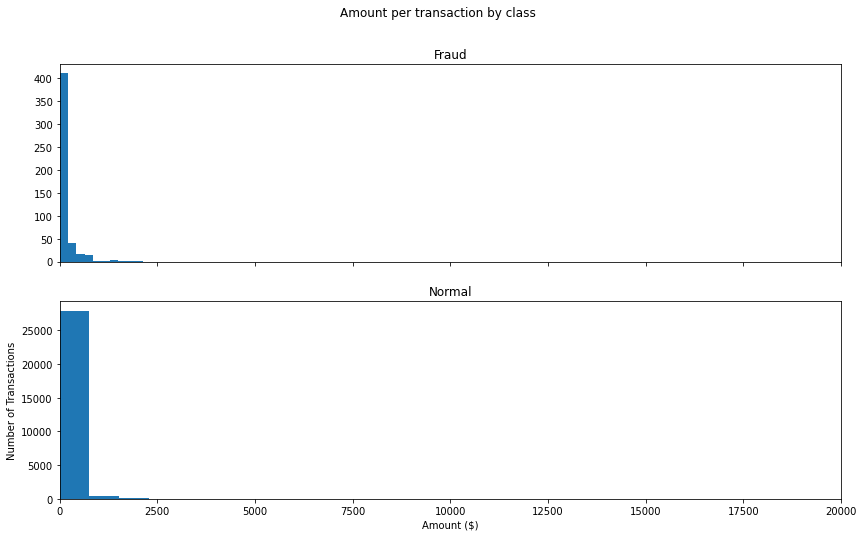

In [156]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 10
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
#plt.yscale('log')
plt.show();

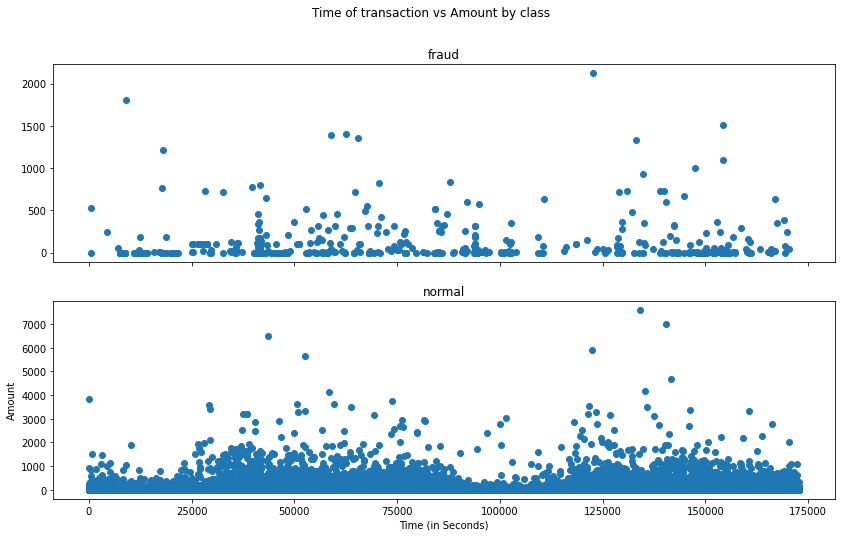

In [157]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)     # Sahte işlemlerin belirli bir zaman aralığında daha sık gerçekleşip gerçekleşmediğini analiz etmek için kullanıyoruz. 
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

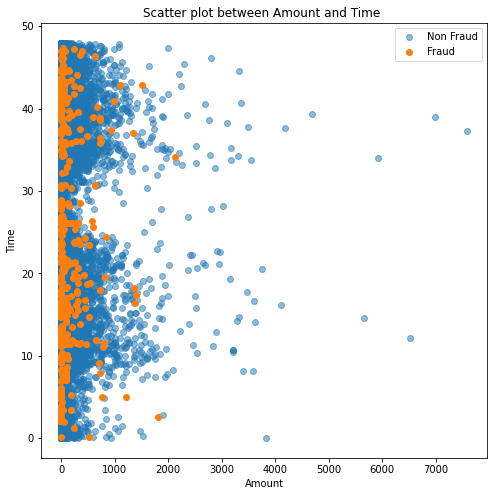

In [158]:
fig = plt.figure(figsize = (8,8))  
plt.scatter(normal.Amount, normal.Time.values/(60*60),alpha=0.5,label='Non Fraud')
plt.scatter(fraud.Amount, fraud.Time.values/(60*60),alpha=1,label='Fraud')
plt.xlabel('Amount')
plt.ylabel('Time')
plt.title('Scatter plot between Amount and Time ')
plt.legend()
plt.show() # Dolandırıcılık işlemlerinin çoğu daha az miktara sahip görünüyor.

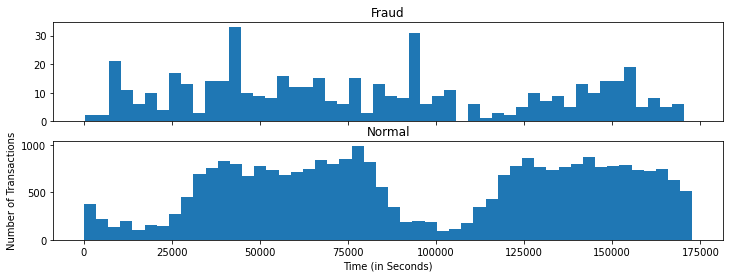

In [159]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()  # Dolandırıcılık işlemlerinin çoğu, 50000 saniye ile 1000000 saniye arasında sürmüş gibi görünüyor.

In [160]:
#Determine the number of fraud and valid transactions in the dataset
outlier_fraction = len(fraud)/float(len(normal))

In [161]:
print(outlier_fraction*100)

1.730444569499156


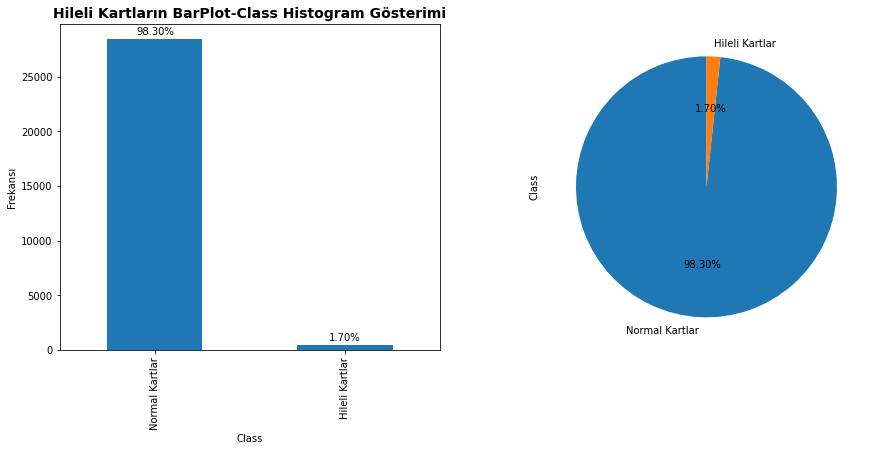

In [162]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.title('Hileli Kartların BarPlot-Class Histogram Gösterimi', fontweight='bold',fontsize=14)
count_of_classes = pd.value_counts(data['Class'], sort = True).sort_index()
ax = count_of_classes.plot(kind = 'bar')
plt.xlabel("Class")
plt.ylabel("Frekansı")
plt.xticks([0,1],["Normal Kartlar","Hileli Kartlar"])

total = float(len(data))

for p in ax.patches: # Yüzdelik değerlerin textini ayarlamak için kullanıyoruz.
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 400,
            '{:1.2f}%'.format(height*100/total),
            ha="center") 


plt.subplot(122)
labels = 'Normal Kartlar', 'Hileli Kartlar'
data["Class"].value_counts().plot.pie(autopct = "%1.2f%%", labels=labels, startangle=90)
plt.show()

In [163]:
print("Fraud Cases : {}".format(len(fraud))) # Yeni dataseti oluşturduğumuzda elimizde kalan fraud ve valid değerler

print("Normal Cases : {}".format(len(normal)))

Fraud Cases : 492
Normal Cases : 28432


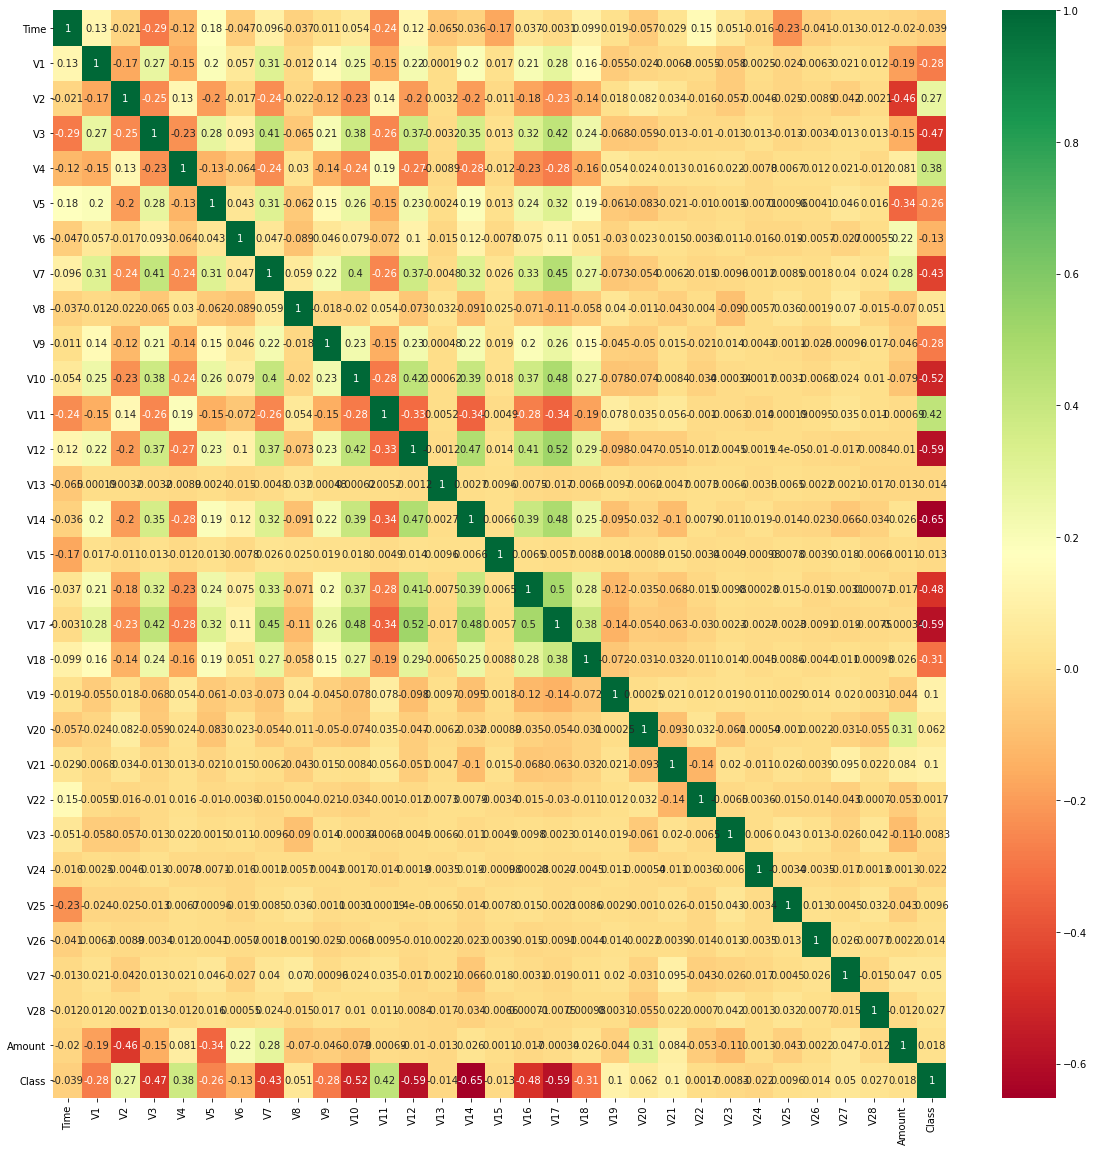

In [164]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [165]:
# Understanding more on the correlation in data:
print("Most important features relative to target variable Class")

corr_initial = data.corr()['Class']
# convert series to dataframe so it can be sorted
corr_initial = pd.DataFrame(corr_initial)
# correct column label from SalePrice to correlation
corr_initial.columns = ["Correlation"]
# sort correlation
corr_initial2 = corr_initial.sort_values(by=['Correlation'], ascending=False)
corr_initial2.head(10)

Most important features relative to target variable Class


,Correlation
Class,1.000000
V11,0.424410
V4,0.378494
V2,0.265378
V19,0.104867
V21,0.102747
V20,0.062132
V8,0.050586
V27,0.050258
V28,0.027472


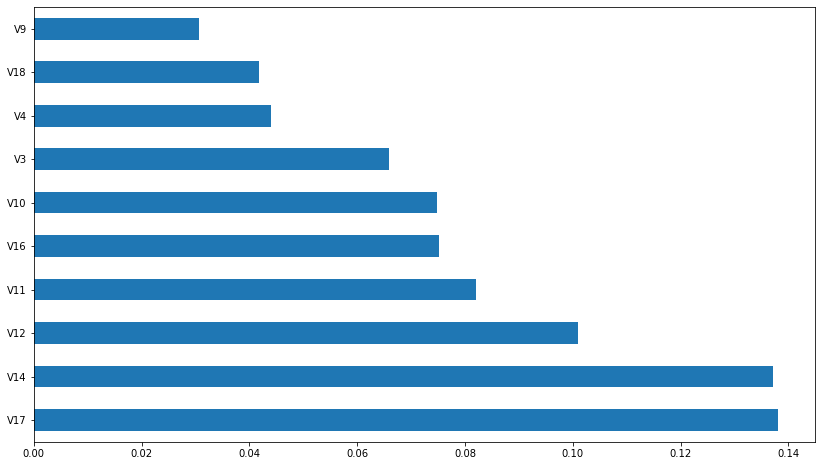

In [178]:
X = data.iloc[:,0:30]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
model.feature_importances_ #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [179]:
#Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28924, 30)
(28924,)


In [180]:
data.drop(['Time', 'V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], axis = 1, inplace = True)

In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28924 entries, 0 to 28923
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V3      28924 non-null  float64
 1   V4      28924 non-null  float64
 2   V9      28924 non-null  float64
 3   V10     28924 non-null  float64
 4   V11     28924 non-null  float64
 5   V12     28924 non-null  float64
 6   V14     28924 non-null  float64
 7   V16     28924 non-null  float64
 8   V17     28924 non-null  float64
 9   V18     28924 non-null  float64
 10  Class   28924 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 2.4 MB


In [183]:
#Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28924, 10)
(28924,)


In [185]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "One Class Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
}

In [186]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 299
Accuracy Score :
0.9896625639607246
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28432
           1       0.69      0.71      0.70       492

    accuracy                           0.99     28924
   macro avg       0.84      0.85      0.85     28924
weighted avg       0.99      0.99      0.99     28924

Local Outlier Factor: 983
Accuracy Score :
0.9660143825197068
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     28432
           1       0.01      0.01      0.01       492

    accuracy                           0.97     28924
   macro avg       0.50      0.50      0.50     28924
weighted avg       0.97      0.97      0.97     28924

One Class Support Vector Machine: 1091
Accuracy Score :
0.962280459134283
Classification Report :
              precision    recall  f1-score   support

           0       1.00  